In [3]:
from typing import Union
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt


class Dataset_Recent(Dataset):
    """
    直近系列情報を活用するためのラッパーデータセットクラス。
    - あるインデックスのデータと、その直近recent_num個分のデータを同時に返す。
    - gapで系列間の間隔を指定可能。
    - strengthを指定すると時系列データに周期的な変動を加えることも可能。
    - __getitem__で(現在データ, 直近データ)または(直近データ, 現在データ)のタプルを返す。
    """
    def __init__(self, dataset, gap: Union[int, tuple, list], recent_num=1, take_post=0, strength=0, **kwargs):
        super().__init__()
        self.more = gap - recent_num + 1
        self.dataset = dataset
        self.gap = gap
        self.recent_num = recent_num
        if strength:
            print("Modify time series with strength =", strength)
            for i in range(3, len(self.dataset.data_y)):
                self.dataset.data_x[i] *= 1 + 0.1 * (i // 24 % strength)

    def _stack(self, data):
        if isinstance(data[0], np.ndarray):
            return np.vstack(data)
        else:
            return torch.stack(data, 0)

    def __getitem__(self, index):
        """
        指定インデックスのデータと、その直近系列データを返す。
        - recent_num=1の場合: (indexのデータ, index+gapのデータ)のタプルを返す。
        - recent_num>1の場合:
            ・current_data: index+gap+recent_num-1のデータ
            ・recent_data: indexからindex+recent_num-1までの直近系列をまとめて返す。
            ・current_dataがタプルでなければ(recent_data, current_data)のタプル。
            ・current_dataがタプルの場合は、各要素ごとに直近系列をまとめて返す。
        - 直近系列はtorch.stackやnp.vstackでまとめてテンソル化される。
        - オンライン学習では，recent_dataで学習し，current_dataで検証する．
        """
        if self.recent_num == 1:
            # recent_num=1の場合：単純に現在のデータとgap分先のデータを返す
            return self.dataset[index], self.dataset[index + self.gap]
        else:
            # recent_num>1の場合：複数の直近系列をまとめて返す
            # current_data: 予測対象となるデータ（gap+recent_num-1分先のデータ）
            current_data = self.dataset[index + self.gap + self.recent_num - 1]

            if not isinstance(current_data, tuple):
                # current_dataがタプルでない場合（単一のテンソル/配列）
                # indexからindex+recent_num-1までの直近系列を取得
                recent_data = tuple(self.dataset[index + n] for n in range(self.recent_num))
                # 直近系列をまとめてテンソル化（_stackでtorch.stackまたはnp.vstack）
                recent_data = self._stack(recent_data)
                # (current_data, recent_data)のタプルを返す
                return current_data, recent_data
            else:
                # current_dataがタプルの場合（複数の要素を持つ）
                # 各要素に対応する空のリストを作成
                recent_data = tuple([] for _ in range(len(current_data)))

                # 直近系列の各時点について
                for past in range(self.recent_num):
                    # index+pastのデータを取得
                    past_data_tuple = self.dataset[index + past]
                    # 各要素（seq_x, seq_y, seq_x_mark, seq_y_markなど）を対応するリストに追加
                    for j, past_data in enumerate(past_data_tuple):
                        recent_data[j].append(past_data)

                # 各要素の直近系列をまとめてテンソル化
                recent_data = tuple(self._stack(recent_d) for recent_d in recent_data)
                # (recent_data, current_data)のタプルを返す
                return recent_data, current_data

    def __len__(self):
        return len(self.dataset) - self.more


In [4]:

# ダミーデータセット: 0,1,2,...の連番を返すだけ
class DummyDataset(Dataset):
    def __init__(self, length=20):
        self.data = np.arange(length).reshape(-1, 1)
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)
    def __len__(self):
        return len(self.data)

dummy = DummyDataset(20)
print('DummyDataset:', [dummy[i].item() for i in range(len(dummy))])



DummyDataset: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0]


In [37]:
# Dataset_Recentの挙動をprintで確認
def show_dataset_recent(gap, recent_num=1, take_post=0, strength=0):
    ds_recent = Dataset_Recent(dummy, gap=gap, recent_num=recent_num, take_post=take_post, strength=strength)
    print(f'--- gap={gap}, recent_num={recent_num}, take_post={take_post} ---')
    for i in range(len(ds_recent)-gap-recent_num-1):
        result = ds_recent[i]
        if recent_num == 1:
            recent, current = result
            print(f'i={i}: recent={recent.item()}, current={current.item()}')
        else:
            recent, current = result
            print(f'i={i}: recent={recent.item()}, current={[v.item() for v in current]}')

In [38]:
# gap=pred_len, recent_num=1

# 例1: gap=2, recent_num=1
show_dataset_recent(gap=3, recent_num=2)

--- gap=3, recent_num=2, take_post=0 ---
i=0: recent=4.0, current=[0.0, 1.0]
i=1: recent=5.0, current=[1.0, 2.0]
i=2: recent=6.0, current=[2.0, 3.0]
i=3: recent=7.0, current=[3.0, 4.0]
i=4: recent=8.0, current=[4.0, 5.0]
i=5: recent=9.0, current=[5.0, 6.0]
i=6: recent=10.0, current=[6.0, 7.0]
i=7: recent=11.0, current=[7.0, 8.0]
i=8: recent=12.0, current=[8.0, 9.0]
i=9: recent=13.0, current=[9.0, 10.0]
i=10: recent=14.0, current=[10.0, 11.0]
i=11: recent=15.0, current=[11.0, 12.0]


In [24]:
# 例2: gap=2, recent_num=3
show_dataset_recent(gap=2, recent_num=3)

--- gap=2, recent_num=3, take_post=0 ---
i=0: y=4.0, x_recent=[0.0, 1.0, 2.0]
i=1: y=5.0, x_recent=[1.0, 2.0, 3.0]
i=2: y=6.0, x_recent=[2.0, 3.0, 4.0]
i=3: y=7.0, x_recent=[3.0, 4.0, 5.0]
i=4: y=8.0, x_recent=[4.0, 5.0, 6.0]
i=5: y=9.0, x_recent=[5.0, 6.0, 7.0]
i=6: y=10.0, x_recent=[6.0, 7.0, 8.0]
i=7: y=11.0, x_recent=[7.0, 8.0, 9.0]
i=8: y=12.0, x_recent=[8.0, 9.0, 10.0]
i=9: y=13.0, x_recent=[9.0, 10.0, 11.0]
i=10: y=14.0, x_recent=[10.0, 11.0, 12.0]
i=11: y=15.0, x_recent=[11.0, 12.0, 13.0]
i=12: y=16.0, x_recent=[12.0, 13.0, 14.0]
i=13: y=17.0, x_recent=[13.0, 14.0, 15.0]


In [9]:
# 可視化: recent_num>1の場合、直近系列の値を折れ線グラフで可視化
def plot_recent_series(gap, recent_num):
    ds_recent = Dataset_Recent(dummy, gap=gap, recent_num=recent_num)
    plt.figure(figsize=(8, 4))
    for i in range(len(ds_recent)):
        y, x_recent = ds_recent[i]
        x_vals = [v.item() for v in x_recent]
        plt.plot(range(recent_num), x_vals, marker='o', label=f'i={i}, y={y.item()}')
    plt.xlabel('recent index')
    plt.ylabel('value')
    plt.title(f'Dataset_Recent: gap={gap}, recent_num={recent_num}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


IndexError: index 20 is out of bounds for axis 0 with size 20

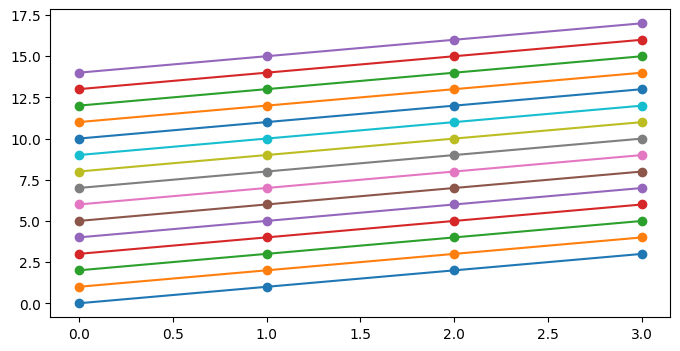

In [10]:

# 例: gap=2, recent_num=4
plot_recent_series(gap=2, recent_num=4)

In [4]:
import torch

current_idx = 1
topk_index = torch.arange(10)
period = 24
pred_len = 48
seq_len = 60
lags = -((current_idx - topk_index) % period) - pred_len
print(lags)
# lagsの最小値は-seq_len+1である．最小値より小さい値はself.periodを加える．
while lags.min() < -seq_len+1:
	lags = torch.where(lags < -seq_len+1, lags+period, lags)
	print(lags)

tensor([-49, -48, -71, -70, -69, -68, -67, -66, -65, -64])
tensor([-49, -48, -47, -46, -45, -44, -43, -42, -41, -40])
